##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title ##### Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bayesian Neural Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/discussion/nn/examples/mnist_variational.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/discussion/nn/examples/mnist_variational.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### 1  Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from discussion import nn as tfp_nn

# Globally Enable XLA
# from tensorflow.python.framework import config
# config.set_optimizer_jit(True)

tfb = tfp.bijectors
tfd = tfp.distributions

### 2  Load Dataset

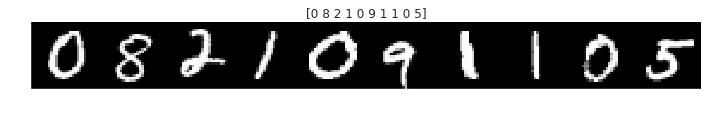

In [0]:
[train_dataset, eval_dataset], datasets_info = tfds.load(
    name='mnist',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True)

def _preprocess(image, label):
  image = tf.cast(image, dtype=tf.float32) / 255.
  label = tf.cast(label, dtype=tf.int32)
  return image, label

train_size = datasets_info.splits['train'].num_examples
batch_size = 32

train_dataset = tfp_nn.util.tune_dataset(
    train_dataset,
    batch_size=batch_size,
    shuffle_size=int(train_size  / 7),
    preprocess_fn=_preprocess)

eval_dataset = tfp_nn.util.tune_dataset(
    eval_dataset,
    preprocess_fn=_preprocess)

x, y = next(iter(eval_dataset.batch(10)))
tfp_nn.util.display_imgs(x, y);

### 3  Define Model

In [0]:
max_pool = tf.keras.layers.MaxPooling2D(  # Has no tf.Variables.
    pool_size=(2, 2),
    strides=(2, 2),
    padding='SAME',
    data_format='channels_last')

model = tfp_nn.Sequential([
  tfp_nn.ConvolutionVariationalFlipout(
      input_size=1,
      output_size=8,
      filter_shape=5,
      padding='SAME',
      penalty_weight=1. / train_size,
      name='conv1'),
  tf.nn.leaky_relu,
  max_pool,  # [28, 28, 8] -> [14, 14, 8]
  tfp_nn.ConvolutionVariationalFlipout(
      input_size=8,
      output_size=16,
      filter_shape=5,
      padding='SAME',
      penalty_weight = 1. / train_size,
      name='conv2'),
  tf.nn.leaky_relu,
  max_pool,  # [14, 14, 16] -> [7, 7, 16]
  tfp_nn.util.flatten_rightmost,
  tfp_nn.AffineVariationalReparameterizationLocal(
      input_size=7 * 7 * 16,
      output_size=10,
      penalty_weight = 1. / train_size,
      name='affine1'),
  lambda x: tfd.Categorical(logits=x, dtype=tf.int32),   
], name='model')

print(model.summary())

=== model ==================================================
  SIZE SHAPE                TRAIN NAME                                    
   200 [5, 5, 1, 8]         True  posterior_kernel_loc:0                  
   200 [5, 5, 1, 8]         True  posterior_kernel_scale:0                
     8 [8]                  True  posterior_bias_loc:0                    
     8 [8]                  True  posterior_bias_scale:0                  
  3200 [5, 5, 8, 16]        True  posterior_kernel_loc:0                  
  3200 [5, 5, 8, 16]        True  posterior_kernel_scale:0                
    16 [16]                 True  posterior_bias_loc:0                    
    16 [16]                 True  posterior_bias_scale:0                  
  7840 [784, 10]            True  posterior_kernel_loc:0                  
  7840 [784, 10]            True  posterior_kernel_scale:0                
    10 [10]                 True  posterior_bias_loc:0                    
    10 [10]                 True  poste

### 4  Train

In [0]:
train_iter = iter(train_dataset)
eval_iter = iter(eval_dataset.batch(1000))

def loss():
  x, y = next(train_iter)
  nll = -tf.reduce_mean(model(x).log_prob(y), axis=-1)
  kl = model.extra_loss
  return nll + kl, (nll, kl)

opt = tf.optimizers.Adam(learning_rate=1e-2)
 
fit = tfp_nn.util.make_fit_op(
    loss,
    opt,
    model.trainable_variables,
    grad_summary_fn=lambda gs: tf.nest.map_structure(tf.norm, gs))

@tf.function(autograph=False)
def eval():
  x, y = next(eval_iter)
  yhat = model(x)
  nll = -tf.reduce_mean(yhat.log_prob(y))
  kl = model.extra_loss
  loss = nll + kl
  acc = tf.reduce_mean(tf.cast(tf.equal(y, yhat.mode()), tf.float32), axis=-1)
  return loss, acc, nll, kl

In [0]:
num_train_steps = 20e3  # @param { isTemplate: true}
num_train_steps = int(num_train_steps)  # Enforce correct type when overridden.
dur_sec = dur_num = 0

for i in range(num_train_steps):
  start = time.time()
  trn_loss, (trn_nll, trn_kl), g = fit()
  stop = time.time()
  dur_sec += stop - start
  dur_num += 1
  if i % 100 == 0 or i == num_train_steps - 1:
    tst_loss, tst_acc, tst_nll, tst_kl = eval()
    f, x = zip(*[
        ('it:{:5}', opt.iterations),
        ('ms/it:{:6.4f}', dur_sec / max(1., dur_num) * 1000.),
        ('tst_acc:{:6.4f}', tst_acc),
        ('trn_loss:{:6.4f}', trn_loss),
        ('tst_loss:{:6.4f}', tst_loss),
        ('tst_nll:{:6.4f}', tst_nll),
        ('tst_kl:{:6.4f}', tst_kl),
        ('sum_norm_grad:{:6.4f}', sum(g)),

    ])
    print('   '.join(f).format(*[getattr(x_, 'numpy', lambda: x_)()
                                 for x_ in x]))
    sys.stdout.flush()
    dur_sec = dur_num = 0
  # if i % 1000 == 0 or i == maxiter - 1:
  #   model.save('/tmp/bnn.npz')

it:    1   ms/it:11894.6071   tst_acc:0.0950   trn_loss:1548.6454   tst_loss:1835.2985   tst_nll:1835.1682   tst_kl:0.1303   sum_norm_grad:1180.7749
it:  101   ms/it:3.6349   tst_acc:0.1200   trn_loss:142.6360   tst_loss:122.9130   tst_nll:122.7722   tst_kl:0.1408   sum_norm_grad:183.3223
it:  201   ms/it:3.5865   tst_acc:0.1080   trn_loss:92.1116   tst_loss:67.6313   tst_nll:67.4811   tst_kl:0.1502   sum_norm_grad:145.4780
it:  301   ms/it:3.6057   tst_acc:0.1240   trn_loss:62.6742   tst_loss:77.2113   tst_nll:77.0472   tst_kl:0.1641   sum_norm_grad:207.3579
it:  401   ms/it:3.6540   tst_acc:0.1810   trn_loss:55.1975   tst_loss:34.8440   tst_nll:34.6665   tst_kl:0.1775   sum_norm_grad:185.4812
it:  501   ms/it:3.5181   tst_acc:0.2030   trn_loss:34.6156   tst_loss:48.4643   tst_nll:48.2741   tst_kl:0.1902   sum_norm_grad:52.9664
it:  601   ms/it:3.5597   tst_acc:0.2180   trn_loss:15.6520   tst_loss:22.7363   tst_nll:22.5361   tst_kl:0.2002   sum_norm_grad:29.9734
it:  701   ms/it:3.518

### 5  Evaluate

In [0]:
# Run inference multiple times...
num_inferences = 10  # @param { isTemplate: true}
num_inferences = int(num_inferences)  # Enforce correct type when overridden.

x_final, y_final = next(iter(eval_dataset.batch(10000)))
@tf.function(autograph=False, experimental_compile=True)
def predicted_logits():
  yhat = model(x_final)
  return yhat.logits_parameter()

avg_logits = []
for i in range(num_inferences):
  yhat = model(x_final)
  avg_logits.append(predicted_logits())
avg_logits = tf.stack(avg_logits, axis=0)
avg_probs = tf.math.exp(tfp.math.reduce_logmeanexp(
    tf.math.log_softmax(avg_logits, axis=-1), axis=0))

Number of examples undecided: 682
Accurary after excluding undecided ones: 0.996351122856


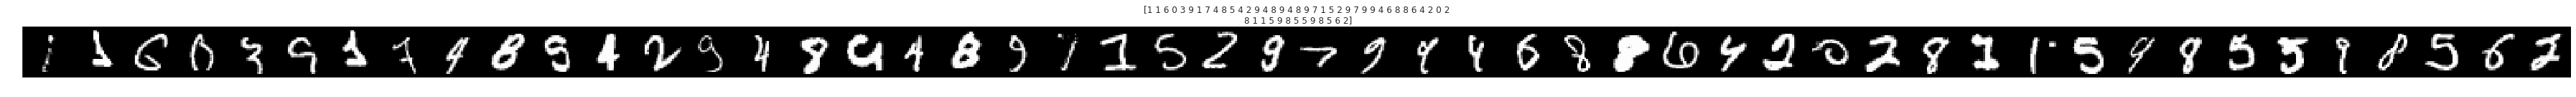

In [0]:
decision = tf.argmax(avg_probs, axis=1, output_type=tf.int32)
confidence = tf.reduce_max(avg_probs, axis=1)
threshold = 0.95

decided_idx = tf.where(confidence > threshold)
ordered = tf.argsort(confidence)

print('Number of examples undecided: {}'.format(10000 - tf.size(decided_idx)))

accurary = tf.reduce_mean(
    tf.cast(tf.equal(tf.gather(y_final, decided_idx),
                     tf.gather(decision, decided_idx)),
            tf.float32))
print('Accurary after excluding undecided ones: {}'.format(accurary))

tfp_nn.util.display_imgs(
     tf.gather(x_final, ordered[0:50]),
     tf.gather(y_final, ordered[0:50]));